In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('2.2.1', '1.2.3')

# Import Packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [3]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

# Import Data

In [4]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


,missing_value,%
Pregnancies,0,0.00
Glucose,5,0.65
BloodPressure,35,4.56
SkinThickness,227,29.56
Insulin,374,48.70
BMI,11,1.43
DiabetesPedigreeFunction,0,0.00
Age,0,0.00
Outcome,0,0.00


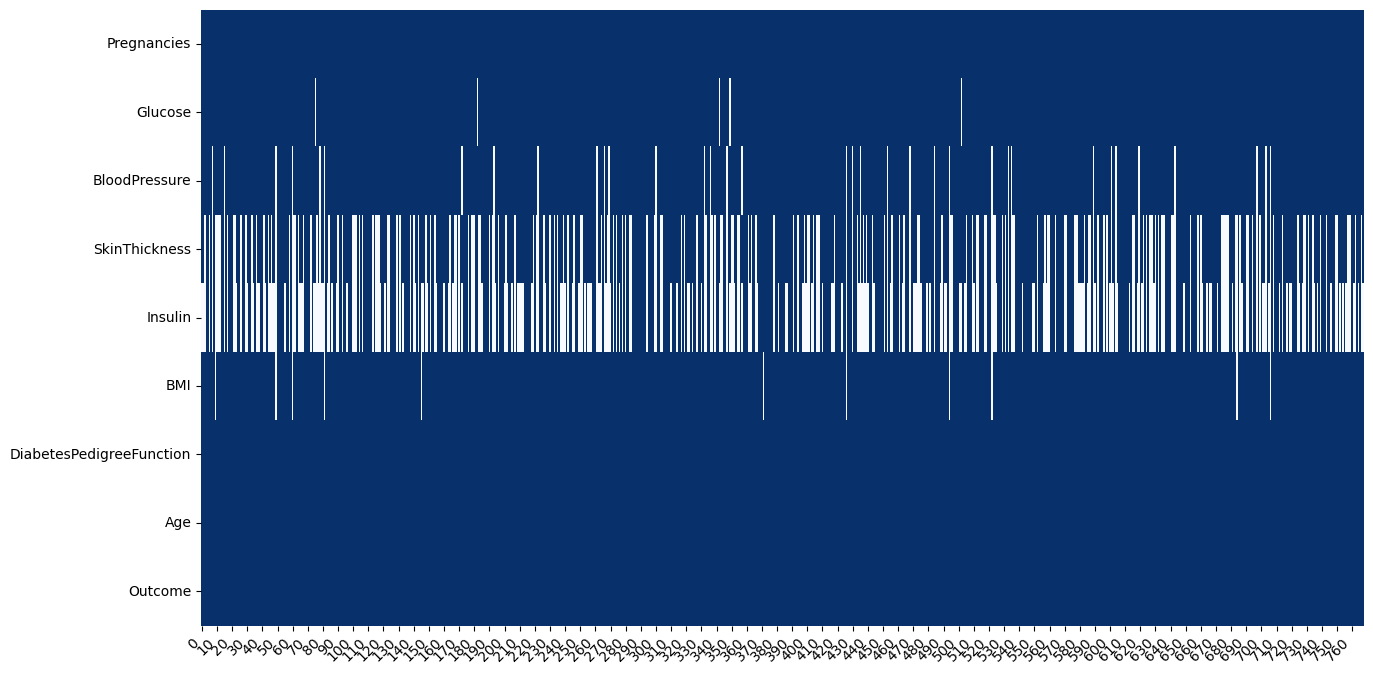

In [5]:
plot_missing_value(df, return_df=True)

In [6]:
df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [7]:
df.drop(columns="Insulin", inplace=True)

# Dataset Splitting

In [8]:
X = df.drop(columns="Outcome")
y = df.Outcome.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data

In [9]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,12.0,27.2,0.580,24
711,5,126.0,78.0,27.0,29.6,0.439,40
373,2,105.0,58.0,40.0,34.9,0.225,25
46,1,146.0,56.0,NaN,29.7,0.564,29
682,0,95.0,64.0,39.0,44.6,0.366,22


In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns),
])

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

# Dataset & Dataloader

In [13]:
# Semua komputasi pytorch menggunakan tipe tensor
# harus convert ke bentuk tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [15]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation -> MCO

In [16]:
X_train.shape

torch.Size([614, 7])

In [26]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training

In [27]:
epochs = 1000
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) # Feedforward
        loss = criterion(output, target)
        loss.backward() # Backpropagation

        optimizer.step() # Update weight
        optimizer.zero_grad() # Syarat pytorch
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
    
    with torch.no_grad():
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) # Feedforward
            loss = criterion(output, target)

            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))
    

    print(f"\rEpoch : {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end=" ")



Epoch : 1000/1000 | train_cost: 0.4393 | test_cost: 0.4872 

# Cost History

In [22]:
import matplotlib.pyplot as plt

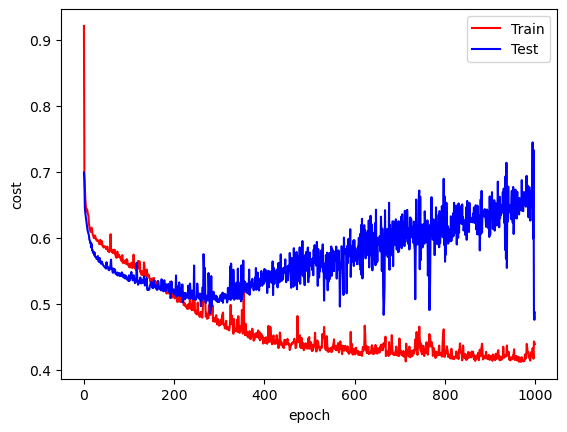

In [29]:
plt.plot(train_cost, '-r', label='Train')
plt.plot(test_cost, '-b', label='Test')
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();